In [1]:
from iterdub import iterdub as ib
from iterpop import iterpop as ip
from keyname import keyname as kn
from matplotlib import pyplot as plt
import matplotlib
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import pathlib
from scipy import stats
import seaborn as sns
from slugify import slugify
import statsmodels.api as sm
import statsmodels.formula.api as smf
from teeplot import teeplot as tp


In [2]:
from conduitpylib.utils import consolidate_merge


In [3]:
nbm.print_metadata()


context: ci
hostname: a23273733bf9
interpreter: 3.6.5 (default, Apr  1 2018, 05:46:30)  [GCC 7.3.0]
nbcellexec: 3
nbname: a=intranode-vs-internode+compute-work=0+simels_per_cpu=1+ext=
nbpath: /opt/conduit/binder/date=2021+project=72k5n/a=intranode-vs-internode/a=intranode-vs-internode+compute-work=0+simels_per_cpu=1+ext=.ipynb
revision: null
session: 8bf95bc8-2c08-4766-89fe-f1f58bf28c07
timestamp: 2021-10-10T18:22:27Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.4.1
iterdub==0.2.0
iterpop==0.3.4
matplotlib==3.3.2
nbmetalog==0.2.6
numpy==1.19.5
pandas==1.1.2
scipy==1.5.4
seaborn==0.11.0
statsmodels==0.12.2
teeplot==0.3.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data


In [4]:
df_inlet = pd.read_csv(
    'https://osf.io/4ys9v/download',
    compression='gzip',
).dropna(
    subset=['Process Instance UUID'],
)
nbm.print_dataframe_summary(*eval(nbm.nvp_expr(
    'df_inlet'
)))


a: df_inlet
digest: 1daa859bb717853ec484fec1734f4e1afa8a7396f1726e898f78c3de7e4799ad
num cols: 42
num cols all na: 2
num cols any na: 12
num na: 1060
num rows: 520
num rows all na: 0
num rows any na: 520
size: 411K



In [5]:
df_outlet = pd.read_csv(
    'https://osf.io/aum7w/download',
    compression='gzip',
).dropna(
    subset=['Process Instance UUID'],
)
nbm.print_dataframe_summary(*eval(nbm.nvp_expr(
    'df_outlet'
)))


a: df_outlet
digest: a585be9d37e0096dda9b1275bf635b909adf905ead3f5ce7df92633084ce4eda
num cols: 68
num cols all na: 6
num cols any na: 22
num na: 3152
num rows: 520
num rows all na: 0
num rows any na: 520
size: 517K



In [6]:
df = consolidate_merge(
    df_inlet,
    df_outlet,
    on=['Process Instance UUID', 'Update'],
    suffixes=(' Inlet', ' Outlet'),
    how='outer',
)
if all(df_inlet['Runtime Seconds Elapsed'] == df_outlet['Runtime Seconds Elapsed']):
    df['Runtime Seconds Elapsed Inlet'] = df['Runtime Seconds Elapsed']
    df['Runtime Seconds Elapsed Outlet'] = df['Runtime Seconds Elapsed']
nbm.print_dataframe_synopsis(*eval(nbm.nvp_expr(
    'df'
)))


a: df
digest: 644b2116757e7bb40ba6e83dd88fa95067150142a6d160ea81b5cfa16d461bdc
manifest:
- ././@LongLink Inlet
- Num Inlets
- Num Puts Attempted
- Num Round Trip Touches Inlet
- Num Try Puts Attempted
- Num Dropped Puts
- Num Blocking Puts
- Num Try Puts That Succeeded
- Num Puts That Succeeded Eventually
- Num Blocking Puts That Succeeded Immediately
- Num Puts That Succeeded Immediately
- Num Puts That Blocked
- Fraction Try Puts Dropped
- Fraction Try Puts That Succeeded
- Fraction Blocking Puts That Blocked
- Fraction Puts That Succeeded Eventually
- Fraction Puts That Succeeded Immediately
- Round Trip Touches Per Attempted Put
- Mean Fraction Try Puts Dropped
- Mean Fraction Try Puts That Succeeded
- Mean Fraction Blocking Puts That Blocked
- Mean Fraction Puts That Succeeded Eventually
- Mean Fraction Puts That Succeeded Immediately
- Mean Round Trip Touches Per Attempted Put
- Row Final Timepoint (ns) Inlet
- Update
- Process Instance UUID
- Source File Inlet
- ././@LongLink Ou

# Prep Data


In [7]:
df = df.astype({
    'Num Inlets' : 'int64',
    'Num Outlets' : 'int64',
    'Num Puts Attempted' : 'int64',
    'Num Try Puts Attempted' : 'int64',
    'Num Blocking Puts' : 'int64',
    'Num Try Puts That Succeeded' : 'int64',
    'Num Puts That Succeeded Eventually' : 'int64',
    'Num Blocking Puts That Succeeded Immediately' : 'int64',
    'Num Puts That Succeeded Immediately' : 'int64',
    'Num Puts That Blocked' : 'int64',
    'Num Dropped Puts' : 'int64',
    'Num Round Trip Touches Inlet' : 'int64',
    'Net Flux Through Duct' : 'int64',
    'proc' : 'int64',
    'Snapshot' : 'int64',
    'Has Execution Blur' : 'bool',
    'Replicate' : 'int64',
    'Async Mode' : 'int64',
    'Num Threads' : 'int64',
    'Num Processes' : 'int64',
    'SLURM_NNODES' : 'int64',
    'SLURM_NTASKS' : 'int64',
    'SLURM_CPUS_ON_NODE' : 'int64',
})


In [8]:
df['Hostname'] = df.apply(
    lambda row: kn.unpack(row['Source File Inlet'])['_hostname'],
    axis=1,
)


In [9]:
df['Num Nodes'] = df['SLURM_NNODES']
df['Num Tasks'] = df['SLURM_NTASKS']
df['Num Simels Per Cpu'] = df['Num Simulation Elements Per Cpu']
df['Num Cpus'] = df['Num Threads'] * df['Num Processes']
df['Allocated Tasks Per Node'] = df['Num Tasks'] // df['Num Nodes']
df['Cpus Per Node'] = df['Allocated Tasks Per Node']
df['Delivery Time Inlet'] = (df['Num Puts Attempted'] - 1) / df['Num Round Trip Touches Inlet']
df['Delivery Time Outlet'] = (df['Num Pulls Attempted'] - 1) / df['Num Round Trip Touches Outlet']
df['Intermittancy'] = df['Num Pulls That Were Laden Immediately'] / df[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df['Inlet-Seconds Elapsed'] = df['Num Inlets'] * df['Runtime Seconds Elapsed Inlet']
df['Outlet-Seconds Elapsed'] = df['Num Outlets'] * df['Runtime Seconds Elapsed Outlet']
df['Latency Simsteps Inlet'] = df['Delivery Time Inlet']
df['Latency Simsteps Outlet'] = df['Delivery Time Inlet']
df['Simstep Period Inlet (s)'] = df['Inlet-Seconds Elapsed'] / df['Num Puts Attempted']
df['Simstep Period Outlet (s)'] =  df['Outlet-Seconds Elapsed'] / df['Num Pulls Attempted']
df['Latency Walltime Inlet (s)'] = df['Latency Simsteps Inlet'] * df['Simstep Period Inlet (s)']
df['Latency Walltime Outlet (s)'] = df['Latency Simsteps Outlet'] * df['Simstep Period Outlet (s)']
df['Log Num Processes'] = np.log(df['Num Processes']) / np.log(4)


In [10]:
row_distiller = lambda row: {k : v for k, v in row.items() if k in ('Num Nodes', 'Num Processes')}
df['Multiprocessing'] = df.apply(
    lambda row: {
        frozenset({'Num Nodes' : 1, 'Num Processes' : 2}.items()) : 'Intranode',
        frozenset({'Num Nodes' : 2, 'Num Processes' : 2}.items()) : 'Internode',
    }[frozenset(row_distiller(row).items())],
    axis=1,
)

multiprocessing_idx_mapper = {
    val : idx
    for idx, val
    in enumerate(df['Multiprocessing'].unique())
}
multiprocessing_idx_mapped_title = ' | '.join(f'{idx} = {val}' for val, idx in multiprocessing_idx_mapper.items())
df[multiprocessing_idx_mapped_title] = df.apply(
    lambda row: multiprocessing_idx_mapper[row['Multiprocessing']],
    axis=1,
)


# Prep DataFrame Variants


In [11]:
# https://stackoverflow.com/a/40629420
df_finalized_observations = df.sort_values('Update', ascending=False).drop_duplicates(['Process Instance UUID'])


In [12]:
df_blurry_snapshots = df[
    df['Has Execution Blur'].astype(bool)
    & (df['Snapshot'] <= 5 )
    # exclude excess, unintended snapshots from runs that took a while to shut down
    # (i.e., from at the 6 minute mark and beyond)
]


In [13]:
df_world_sum = df_finalized_observations.groupby([
    'Replicate',
    'Async Mode',
    'Num Processes',
    'Num Nodes',
    'Num Simels Per Cpu',
    'Allocated Tasks Per Node',
    'Cpus Per Node',
    'Multiprocessing',
    multiprocessing_idx_mapped_title,
],  as_index=False).sum()

df_world_sum['Fraction Messages Utilized'] = df_world_sum['Num Reads That Were Fresh'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Fraction Messages Delivered'] = df_world_sum['Num Try Puts That Succeeded'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Delivery Failure Rate'] = 1.0 - df_world_sum['Fraction Messages Delivered']
df_world_sum['Fraction Messages Dropped'] = df_world_sum['Delivery Failure Rate']
df_world_sum['Fraction Try Pulls That Were Laden'] = df_world_sum['Num Try Pulls That Were Laden'] / df_world_sum['Num Try Pulls Attempted']
df_world_sum['Round Trip Touches Per Attempted Pull'] = df_world_sum['Num Round Trip Touches Outlet'] / df_world_sum['Num Try Pulls Attempted']
df_world_sum['Round Trip Touches Per Attempted Put'] = df_world_sum['Num Round Trip Touches Inlet'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Num Inflight Messages'] = 2.0 / df_world_sum['Round Trip Touches Per Attempted Put'] - 1
df_world_sum['Fraction Duct Flux Stepped Through'] = df_world_sum['Num Revisions Pulled'] / df_world_sum['Net Flux Through Duct']
df_world_sum['Fraction Duct Flux Jumped Over'] = 1.0 - df_world_sum['Fraction Duct Flux Stepped Through']
df_world_sum['Round Trip Touches Per Runtime Second'] = df_world_sum['Num Round Trip Touches Inlet'] / df_world_sum['Runtime Seconds Elapsed Inlet']
df_world_sum['Latency Simsteps Inlet'] = (df_world_sum['Num Puts Attempted'] - 1) / df_world_sum['Num Round Trip Touches Inlet']
df_world_sum['Latency Simsteps Outlet'] = (df_world_sum['Num Pulls Attempted'] - 1) / df_world_sum['Num Round Trip Touches Outlet']
df_world_sum['Delivery Clumpiness'] = 1.0 - df_world_sum['Num Pulls That Were Laden Immediately'] / df_world_sum[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df_world_sum['Intermittancy'] = df_world_sum['Delivery Clumpiness']
df_world_sum['Simstep Period Inlet (s)'] = df_world_sum['Inlet-Seconds Elapsed'] / df_world_sum['Num Puts Attempted']
df_world_sum['Simstep Period Outlet (s)'] = df_world_sum['Outlet-Seconds Elapsed'] / df_world_sum['Num Pulls Attempted']
df_world_sum['Latency Walltime Inlet (s)'] = df_world_sum['Latency Simsteps Inlet'] * df_world_sum['Simstep Period Inlet (s)']
df_world_sum['Latency Walltime Outlet (s)'] = df_world_sum['Latency Simsteps Outlet'] * df_world_sum['Simstep Period Outlet (s)']


In [14]:
df_snapshot_diffs = df_blurry_snapshots.groupby(
    [
        'Process Instance UUID',
        'Snapshot',
        # subsequent items aren't meaningful to groupby
        # but are just included so they pass through untouched
        'Async Mode',
        'Num Nodes',
        'Allocated Tasks Per Node',
        'Cpus Per Node',
        'Num Processes',
        'Log Num Processes',
        'Num Simels Per Cpu',
        'Replicate',
        'proc',
        'Hostname',
        'Num Inlets',
        'Num Outlets',
        'Execution Instance UUID',
        'Num Threads',
        'Multiprocessing',
        multiprocessing_idx_mapped_title,

    ],
    as_index=False,
).aggregate({
    'Num Puts Attempted' : np.ptp,
    'Num Try Puts Attempted' : np.ptp,
    'Num Blocking Puts'  : np.ptp,
    'Num Try Puts That Succeeded' : np.ptp,
    'Num Puts That Succeeded Eventually' : np.ptp,
    'Num Blocking Puts That Succeeded Immediately' : np.ptp,
    'Num Puts That Succeeded Immediately' : np.ptp,
    'Num Puts That Blocked' : np.ptp,
    'Num Dropped Puts' : np.ptp,
    'Num Reads Performed' : np.ptp,
    'Num Reads That Were Fresh' : np.ptp,
    'Num Reads That Were Stale' : np.ptp,
    'Num Revisions Pulled' : np.ptp,
    'Num Try Pulls Attempted' : np.ptp,
    'Num Blocking Pulls' : np.ptp,
    'Num Blocking Pulls That Blocked' : np.ptp,
    'Num Revisions From Try Pulls' : np.ptp,
    'Num Revisions From Blocking Pulls' : np.ptp,
    'Num Pulls Attempted' : np.ptp,
    'Num Pulls That Were Laden Eventually' : np.ptp,
    'Num Blocking Pulls That Were Laden Immediately' : np.ptp,
    'Num Blocking Pulls That Were Laden Eventually' : np.ptp,
    'Num Pulls That Were Laden Immediately' : np.ptp,
    'Num Try Pulls That Were Laden' : np.ptp,
    'Num Try Pulls That Were Unladen' : np.ptp,
    'Net Flux Through Duct' : np.ptp,
    'Num Round Trip Touches Inlet' : np.ptp,
    'Num Round Trip Touches Outlet' : np.ptp,
# why are these missing?
#     'Row Initial Timepoint (ns) Inlet' : np.ptp,
#     'Row Initial Timepoint (ns) Outlet' : np.ptp,
    'Row Final Timepoint (ns) Inlet' : np.ptp,
    'Row Final Timepoint (ns) Outlet' : np.ptp,
    'Runtime Seconds Elapsed Inlet' : np.mean,
    'Runtime Seconds Elapsed Outlet' : np.mean,
})


In [15]:
df_snapshot_diffs['Fraction Messages Delivered'] = (
    df_snapshot_diffs['Num Try Puts That Succeeded']
    / df_snapshot_diffs['Num Try Puts Attempted']
)
df_snapshot_diffs['Delivery Success Rate'] = (
    df_snapshot_diffs['Num Try Puts That Succeeded']
    / df_snapshot_diffs['Num Try Puts Attempted']
)
df_snapshot_diffs['Delivery Failure Rate'] = 1 - df_snapshot_diffs['Delivery Success Rate']
df_snapshot_diffs['Fraction Messages Dropped'] = df_snapshot_diffs['Delivery Failure Rate']
df_snapshot_diffs['Fraction Try Pulls That Were Laden'] = (
    df_snapshot_diffs['Num Try Pulls That Were Laden']
    / df_snapshot_diffs['Num Try Pulls Attempted']
)

df_snapshot_diffs['Round Trip Touches Per Attempted Put'] = (
    df_snapshot_diffs['Num Round Trip Touches Inlet']
) / df_snapshot_diffs['Num Try Puts Attempted']

df_snapshot_diffs['Round Trip Touches Per Attempted Pull'] = (
    df_snapshot_diffs['Num Round Trip Touches Outlet']
) / df_snapshot_diffs['Num Try Pulls Attempted']

df_snapshot_diffs['Round Trip Touches Per Runtime Nanosecond'] = (
    df_snapshot_diffs['Num Round Trip Touches Outlet']
) / df_snapshot_diffs['Row Final Timepoint (ns) Outlet']

df_snapshot_diffs['Latency Simsteps Inlet'] = df_snapshot_diffs['Num Puts Attempted'] / df_snapshot_diffs['Num Round Trip Touches Inlet']
df_snapshot_diffs['Latency Simsteps Outlet'] = df_snapshot_diffs['Num Pulls Attempted'] / df_snapshot_diffs['Num Round Trip Touches Outlet']
df_snapshot_diffs['Delivery Clumpiness'] = 1.0 - df_snapshot_diffs['Num Pulls That Were Laden Immediately'] / df_snapshot_diffs[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df_snapshot_diffs['Intermittancy'] = df_snapshot_diffs['Delivery Clumpiness']
df_snapshot_diffs['Inlet-Nanoseconds Elapsed'] = df_snapshot_diffs['Num Inlets'] * df_snapshot_diffs['Row Final Timepoint (ns) Inlet']
df_snapshot_diffs['Outlet-Nanoseconds Elapsed'] = df_snapshot_diffs['Num Outlets'] * df_snapshot_diffs['Row Final Timepoint (ns) Outlet']
df_snapshot_diffs['Simsteps Elapsed Inlet'] = df_snapshot_diffs['Num Puts Attempted'] / df_snapshot_diffs['Num Inlets']
df_snapshot_diffs['Simsteps Elapsed Outlet'] = df_snapshot_diffs['Num Pulls Attempted'] / df_snapshot_diffs['Num Outlets']
df_snapshot_diffs['Simstep Period Inlet (ns)'] = df_snapshot_diffs['Inlet-Nanoseconds Elapsed'] / df_snapshot_diffs['Num Puts Attempted']
df_snapshot_diffs['Simstep Period Outlet (ns)'] = df_snapshot_diffs['Outlet-Nanoseconds Elapsed'] / df_snapshot_diffs['Num Pulls Attempted']
df_snapshot_diffs['Latency Walltime Inlet (ns)'] = df_snapshot_diffs['Latency Simsteps Inlet'] * df_snapshot_diffs['Simstep Period Inlet (ns)']
df_snapshot_diffs['Latency Walltime Outlet (ns)'] = df_snapshot_diffs['Latency Simsteps Outlet'] * df_snapshot_diffs['Simstep Period Outlet (ns)']


In [16]:
df_snapshot_diffs = df_snapshot_diffs.astype({
    'Num Inlets' : 'int64',
    'Num Outlets' : 'int64',
    'proc' : 'int64',
    'Snapshot' : 'int64',
    'Replicate' : 'int64',
    'Async Mode' : 'int64',
    'Num Threads' : 'int64',
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Nodes' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',

})


# End-state Data Analysis

This data appears to be skewed by ragged network launch/completion.


In [17]:
def facet_boxplot(*, data, col=None, row=None, x, y, showfliers=False):
    g = sns.FacetGrid(
        data,
        col=col if col is not None and data[col].nunique() > 1 else None,
        row=row if row is not None and data[row].nunique() > 1 else None,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.boxplot,
        x,
        y,
        showfliers=showfliers,
    )


## Latency Walltime


teeplots/simstep-walltime-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-walltime-inlet-s+ext=.pdf
teeplots/simstep-walltime-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-walltime-inlet-s+ext=.png


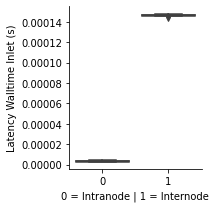

In [18]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Latency Walltime Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='simstep-walltime-inlet-s',
)


teeplots/simstep-walltime-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-walltime-outlet-s+ext=.pdf
teeplots/simstep-walltime-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-walltime-outlet-s+ext=.png


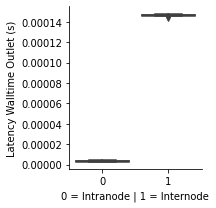

In [19]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Latency Walltime Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='simstep-walltime-outlet-s',
)


## Latency Simsteps


teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.pdf
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.png


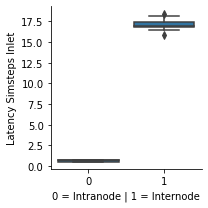

In [20]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Latency Simsteps Inlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='latency-simsteps-inlet',
)


teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.pdf
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.png


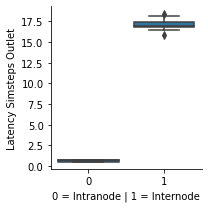

In [21]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Latency Simsteps Outlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='latency-simsteps-outlet',
)


## Delivery Failure Rate


teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.pdf
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.png


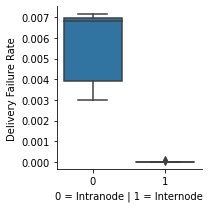

In [22]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,

    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Delivery Failure Rate',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='delivery-failure-rate',
)


## Delivery Clumpiness


teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.pdf
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.png


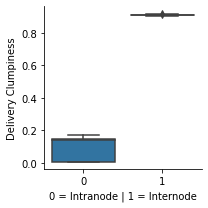

In [23]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Delivery Clumpiness',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='delivery-clumpiness',
)


## Simstep Period


teeplots/simstep-period-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=simstep-period-inlet-s+ext=.pdf
teeplots/simstep-period-inlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=simstep-period-inlet-s+ext=.png


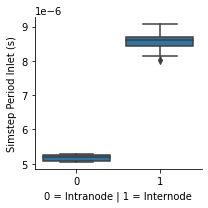

In [24]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Simstep Period Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='simstep-period-inlet-s',
)


teeplots/simstep-period-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=simstep-period-outlet-s+ext=.pdf
teeplots/simstep-period-outlet-s/row=num-simels-per-cpu+transform=endstate_sumedbyrep+viz=facet-boxplot+x=0-intranode-1-internode+y=simstep-period-outlet-s+ext=.png


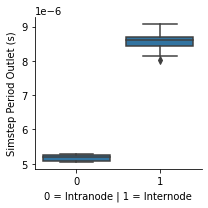

In [25]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    row='Num Simels Per Cpu',
    x=multiprocessing_idx_mapped_title,
    y='Simstep Period Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    },
    teeplot_subdir='simstep-period-outlet-s',
)


# Live Snapshot Analysis


In [26]:
def facet_barplot(*, data, col=None, row=None, x, y, hue=None):
    g = sns.FacetGrid(
        data,
        col=col if col is not None and data[col].nunique() > 1 else None,
        row=row if row is not None and data[row].nunique() > 1 else None,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.barplot,
        x=x,
        y=y,
        hue=hue,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)


In [27]:
def facet_boxplot_withfliers(*, data, col=None, row=None, x, y, hue=None):
    g = sns.FacetGrid(
        data,
        col=col if col is not None and data[col].nunique() > 1 else None,
        row=row if row is not None and data[row].nunique() > 1 else None,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.boxplot,
        x=x,
        y=y,
        hue=hue,
        showfliers=True,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)


In [28]:
def facet_boxplot_nofliers(*, data, col=None, row=None, x, y, hue=None):
    g = sns.FacetGrid(
        data,
        col=col if col is not None and data[col].nunique() > 1 else None,
        row=row if row is not None and data[row].nunique() > 1 else None,
        margin_titles=True,
        sharey='row',
    )
    g.map_dataframe(
        sns.boxplot,
        x=x,
        y=y,
        hue=hue,
        showfliers=False,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)


## Latency Walltime


teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.png
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.png
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/latency-walltime-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-wal

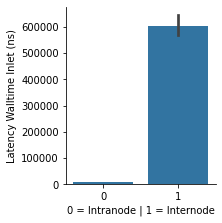

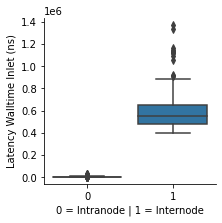

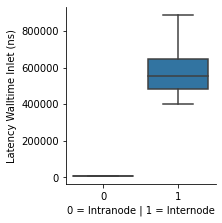

In [29]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Walltime Inlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-inlet-ns',
    )


In [30]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Latency Walltime Inlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Latency Walltime Inlet (ns)               
                                                     mean         median
0 = Intranode | 1 = Internode                                           
0                                             7772.731755    6948.257607
1                                           604242.067055  553529.603270

teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.png
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.png
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/latency-walltime-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=

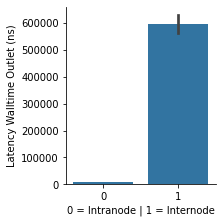

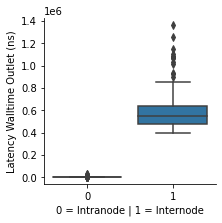

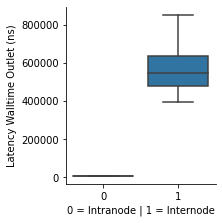

In [31]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Walltime Outlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-outlet-ns',
    )


In [32]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Latency Walltime Outlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Latency Walltime Outlet (ns)               
                                                      mean         median
0 = Intranode | 1 = Internode                                            
0                                              7687.976899    6933.554271
1                                            596442.984158  547970.222355

## Latency Simsteps


teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.pdf
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.png
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.pdf
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.png
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.pdf
teeplots/latency-simsteps-inlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.png


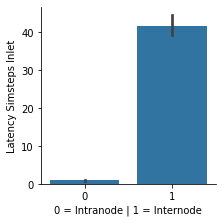

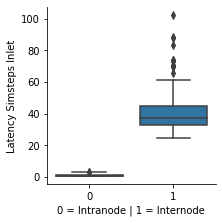

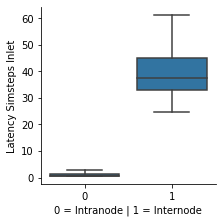

In [33]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Simsteps Inlet',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-inlet',
    )


In [34]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Latency Simsteps Inlet' : [
        np.mean,
        np.median,
    ],
})


Latency Simsteps Inlet           
                                                mean     median
0 = Intranode | 1 = Internode                                  
0                                           1.005012   0.751599
1                                          41.805913  37.397597

teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.pdf
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.png
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.pdf
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.png
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.pdf
teeplots/latency-simsteps-outlet/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.png


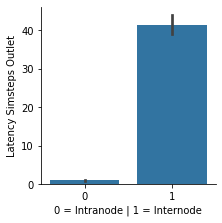

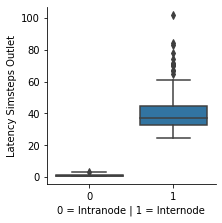

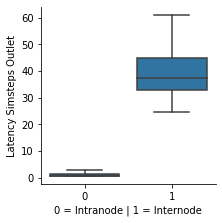

In [35]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Simsteps Outlet',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-outlet',
    )


In [36]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Latency Simsteps Outlet' : [
        np.mean,
        np.median,
    ],
})


Latency Simsteps Outlet           
                                                 mean     median
0 = Intranode | 1 = Internode                                   
0                                            0.998186   0.745325
1                                           41.406816  37.360602

## Delivery Failure Rate


teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.pdf
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.png
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.pdf
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.png
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.pdf
teeplots/delivery-failure-rate/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.png


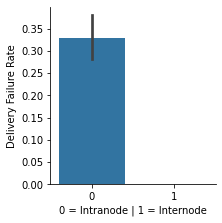

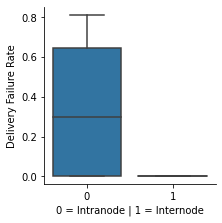

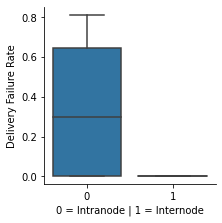

In [37]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Delivery Failure Rate',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-failure-rate',
    )


In [38]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Delivery Failure Rate' : [
        np.mean,
        np.median,
    ],
})


Delivery Failure Rate          
                                               mean    median
0 = Intranode | 1 = Internode                                
0                                          0.329413  0.299809
1                                          0.000000  0.000000

## Delivery Clumpiness


teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.pdf
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.png
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.pdf
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.png
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.pdf
teeplots/delivery-clumpiness/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.png


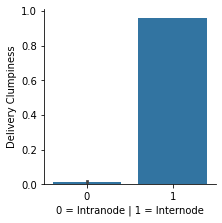

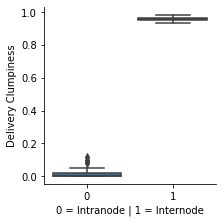

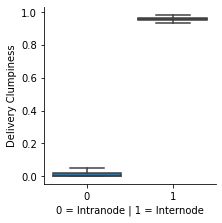

In [39]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Delivery Clumpiness',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-clumpiness',
    )


In [40]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Delivery Clumpiness' : [
        np.mean,
        np.median,
    ],
})


Delivery Clumpiness          
                                             mean    median
0 = Intranode | 1 = Internode                              
0                                        0.013842  0.002099
1                                        0.958519  0.957436

## Simstep Period


teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.pdf
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.png
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.pdf
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.png
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.pdf
teeplots/simstep-period-inlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.png


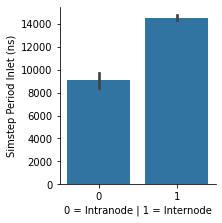

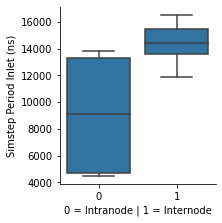

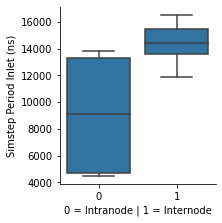

In [41]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Simstep Period Inlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-inlet-ns',
    )


In [42]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Simstep Period Inlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Simstep Period Inlet (ns)              
                                                   mean        median
0 = Intranode | 1 = Internode                                        
0                                           9073.360106   9114.448131
1                                          14534.253956  14464.317468

teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.pdf
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-barplot+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.png
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.pdf
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-withfliers+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.png
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.pdf
teeplots/simstep-period-outlet-ns/row=num-simels-per-cpu+transform=snapshot_diffs+viz=facet-boxplot-nofliers+x=0-intranode-1-internode+y=simstep-period-outlet-

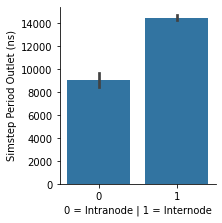

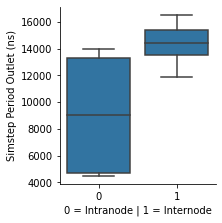

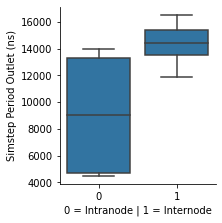

In [43]:
for viz in facet_barplot, facet_boxplot_withfliers, facet_boxplot_nofliers:
    tp.tee(
        viz,
        data=df_snapshot_diffs,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Simstep Period Outlet (ns)',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-outlet-ns',
    )


In [44]:
# adapted from https://stackoverflow.com/a/13592901
df_snapshot_diffs.groupby([
    multiprocessing_idx_mapped_title,
]).agg({
    'Simstep Period Outlet (ns)' : [
        np.mean,
        np.median,
    ],
})


Simstep Period Outlet (ns)              
                                                    mean        median
0 = Intranode | 1 = Internode                                         
0                                            9042.666541   9050.330912
1                                           14481.869199  14449.132639

# Model Fits


In [45]:
def make_regression_row(*, data, independent_variable, dependent_variable, regression, row_filter):

    filtered_data = data[ data.apply(eval(row_filter), axis=1) ]

    regfun = {
        'Ordinary Least Squares Regression' : smf.ols,
        'Quantile Regression' : smf.quantreg,
    }[regression]
    model = regfun(f"Q('{dependent_variable}') ~ Q('{independent_variable}')", filtered_data)
    fit_model = model.fit()

    slope = fit_model.params[f"Q('{independent_variable}')"]
    intercept = fit_model.params['Intercept']

    slope_ci_lb, slope_ci_ub = fit_model.conf_int().loc[f"Q('{independent_variable}')"].tolist()
    intercept_ci_lb, intercept_ci_ub = fit_model.conf_int().loc['Intercept'].tolist()

    p = fit_model.pvalues.loc[f"Q('{independent_variable}')"]

    # normalize to "control", i.e., lowest num processes observed
    effect_size_normalization_data = data[
        data[independent_variable] == data[independent_variable].min()
    ][dependent_variable]
    effect_size_normalization_factor = {
        'Ordinary Least Squares Regression' : lambda x: x.mean(),
        'Quantile Regression' : lambda x: x.median(),
    }[regression](effect_size_normalization_data)
    relative_effect_size = slope / effect_size_normalization_factor
    relative_effect_size_ci_lb = slope_ci_lb / effect_size_normalization_factor
    relative_effect_size_ci_ub = slope_ci_ub / effect_size_normalization_factor
    relative_effect_size_ci_width = (
        relative_effect_size_ci_ub
        - relative_effect_size_ci_lb
    )

    is_significant = p < 0.05 if np.isfinite(p) else None

    res = {
        'Independent Variable' : independent_variable,
        'Dependent Variable' : dependent_variable,
        'Dependent Variable Slug' : slugify(dependent_variable),
        'Cpus Per Node' : ib.dub( data['Cpus Per Node'] ),
        'Num Simels Per Cpu' : ip.pophomogeneous( data['Num Simels Per Cpu'] ),
        'Slope Estimate' : slope,
        'Slope Estimate 95% CI Lower Bound' : slope_ci_lb,
        'Slope Estimate 95% CI Upper Bound' : slope_ci_ub,
        'Absolute Effect Size' : slope,
        'Absolute Effect Size 95% CI Lower Bound' : slope_ci_lb,
        'Absolute Effect Size 95% CI Upper Bound' : slope_ci_ub,
        'Absolute Effect Size 95% CI Width' : slope_ci_ub - slope_ci_lb,
        'Relative Effect Size' : relative_effect_size,
        'Relative Effect Size 95% CI Lower Bound' : relative_effect_size_ci_lb,
        'Relative Effect Size 95% CI Upper Bound' : relative_effect_size_ci_ub,
        'Relative Effect Size 95% CI Width' : relative_effect_size_ci_width,
        'Intercept Estimate' : intercept,
        'Intercept Estimate 95% CI Lower Bound' : intercept_ci_lb,
        'Intercept Estimate 95% CI Upper Bound' : intercept_ci_ub,
        'R^2' : fit_model.rsquared,
        'p' : fit_model.pvalues.loc[f"Q('{independent_variable}')"],
        'Significant?' : is_significant,
        'Significant Effect Sign' : (
            '-' if is_significant and slope < 0
            else '+' if is_significant and slope > 0
            else '0' if is_significant is not None
            else None
        ),
        'n' : len(filtered_data),
        'Filter' : row_filter,
        'Num Processes' : ib.dub(filtered_data['Num Processes']),
        'Num Processes Prettyprint' : (
            '/'.join(filtered_data['Num Processes'].sort_values().astype(str).unique())
        ),
        'Regression Model' : regression,
        'Regression Model Slug' : slugify(regression),
        'Statistic' : {
            'Ordinary Least Squares Regression' : 'mean',
            'Quantile Regression' : 'median',
        }[regression],
    }

    # dump regression summary to file
    summary_filename = kn.pack({
        **{
            'a' : 'regression_summary',
            'ext' : '.txt',
        },
        **{
            slugify(k) : slugify(str(v))
            for k, v in res.items()
            if k in [
                'Independent Variable',
                'Dependent Variable',
                'Cpus Per Node',
                'Num Simels Per Cpu',
                'Regression Model',
            ]
        },
    })

    pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
    with open(f'outplots/{summary_filename}', 'w') as file:
        print(fit_model.summary(), file=file)

    return res


In [46]:
dependent_variables = [
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Delivery Failure Rate',
    'Delivery Clumpiness',
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
]

# best-case approximation to replace infs/nans
# see listings of infs/nans below
df_snapshot_diffs_copy = df_snapshot_diffs.copy()
df_snapshot_diffs_copy['Latency Walltime Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)
df_snapshot_diffs_copy['Latency Walltime Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)
df_snapshot_diffs_copy['Latency Simsteps Inlet'] = (
    df_snapshot_diffs_copy['Num Puts Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)
df_snapshot_diffs_copy['Latency Simsteps Outlet'] = (
    df_snapshot_diffs_copy['Num Pulls Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)
df_snapshot_diffs_copy['Simstep Period Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Puts Attempted'], 1)
)
df_snapshot_diffs_copy['Simstep Period Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Pulls Attempted'], 1)
)

regression_data_tuples = [
    (
        'Ordinary Least Squares Regression',
        df_snapshot_diffs.groupby([
            'Execution Instance UUID',
        ]).mean().reset_index().astype({
            'Num Processes' : 'int64',
            'Allocated Tasks Per Node' : 'int64',
            'Cpus Per Node' : 'int64',
            'Num Simels Per Cpu' : 'int64',
        })
    ),
    (
        'Quantile Regression',
        df_snapshot_diffs.groupby([
            'Execution Instance UUID',
        ]).median().reset_index().astype({
            'Num Processes' : 'int64',
            'Allocated Tasks Per Node' : 'int64',
            'Cpus Per Node' : 'int64',
            'Num Simels Per Cpu' : 'int64',
        })
    ),
]

row_filters = [
    'lambda row: True',
]

regression_results = pd.DataFrame.from_records([
    make_regression_row(
        data=data_subset,
        independent_variable=multiprocessing_idx_mapped_title,
        dependent_variable=dependent_variable,
        regression=regression,
        row_filter=row_filter,
    )
    for row_filter in row_filters
    for regression, data in regression_data_tuples
    for _, data_subset in data.groupby([
        'Num Simels Per Cpu',
    ])
    for dependent_variable in dependent_variables
])


In [47]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

regression_results[ ~np.isfinite(regression_results['p']) ]


,Independent Variable,Dependent Variable,Dependent Variable Slug,Cpus Per Node,Num Simels Per Cpu,Slope Estimate,Slope Estimate 95% CI Lower Bound,Slope Estimate 95% CI Upper Bound,Absolute Effect Size,Absolute Effect Size 95% CI Lower Bound,Absolute Effect Size 95% CI Upper Bound,Absolute Effect Size 95% CI Width,Relative Effect Size,Relative Effect Size 95% CI Lower Bound,Relative Effect Size 95% CI Upper Bound,Relative Effect Size 95% CI Width,Intercept Estimate,Intercept Estimate 95% CI Lower Bound,Intercept Estimate 95% CI Upper Bound,R^2,p,Significant?,Significant Effect Sign,n,Filter,Num Processes,Num Processes Prettyprint,Regression Model,Regression Model Slug,Statistic


In [48]:
input_attrs = pd.DataFrame.from_records([
    {
        k : v
        for k, v in kn.unpack(source_filename).items()
        if k and k[0] != '_' and k != 'ext'
    }
    for source_filename in [
        *df['Source File Inlet'].unique(),
        *df['Source File Outlet'].unique(),
    ]
]).dropna(
    axis='columns',
    how='any',
)

out_filename = lambda readability: kn.pack({
    **{
        col : ib.dub(input_attrs[col])
        for col in input_attrs.columns
    },
    **{
        'a' : f'intranode_vs_internode_regression_results',
        'readability' : readability,
        'ext' : '.csv',
    },
})

out_filepath = f"outplots/{out_filename('human')}"
print(out_filepath)

pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
regression_results.to_csv(
    out_filepath,
    index=False,
)

out_filepath = f"outplots/{out_filename('latexcsvreader')}"
print(out_filepath)

pathlib.Path('outplots').mkdir(parents=True, exist_ok=True)
regression_results.rename(
    columns=lambda col: ''.join(filter(str.isalnum, col)),
).to_csv(
    out_filepath,
    index=False,
    float_format=lambda col: [
        '{:_.0f}'.format(float(f'{x:.2g}')).replace('_', "'")
         if 10 < abs(x) < 10e5
         else f'{x:.2g}' for x in col
    ],
    na_rep='NaN',
)


outplots/a=intranode_vs_internode_regression_results+async_mode=3+impl=proc+nproc=2+nthread=1+proc=0-1+readability=human+replicate=0-9+slurm_nnodes=1-2+slurm_ntasks=2+subject=inlet~outlet+view=summary+ext=.csv
outplots/a=intranode_vs_internode_regression_results+async_mode=3+impl=proc+nproc=2+nthread=1+proc=0-1+readability=latexcsvreader+replicate=0-9+slurm_nnodes=1-2+slurm_ntasks=2+subject=inlet~outlet+view=summary+ext=.csv


In [49]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
regression_results


,Independent Variable,Dependent Variable,Dependent Variable Slug,Cpus Per Node,Num Simels Per Cpu,Slope Estimate,Slope Estimate 95% CI Lower Bound,Slope Estimate 95% CI Upper Bound,Absolute Effect Size,Absolute Effect Size 95% CI Lower Bound,Absolute Effect Size 95% CI Upper Bound,Absolute Effect Size 95% CI Width,Relative Effect Size,Relative Effect Size 95% CI Lower Bound,Relative Effect Size 95% CI Upper Bound,Relative Effect Size 95% CI Width,Intercept Estimate,Intercept Estimate 95% CI Lower Bound,Intercept Estimate 95% CI Upper Bound,R^2,p,Significant?,Significant Effect Sign,n,Filter,Num Processes,Num Processes Prettyprint,Regression Model,Regression Model Slug,Statistic
0,0 = Intranode | 1 = Internode,Latency Walltime Inlet (ns),latency-walltime-inlet-ns,1-2,1,596469.335300,530869.772103,662068.898497,596469.335300,530869.772103,662068.898497,131199.126394,76.738701,68.298996,85.178406,16.879410,7772.731755,-38613.164224,54158.627735,0.952992,2.124099e-13,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
1,0 = Intranode | 1 = Internode,Latency Walltime Outlet (ns),latency-walltime-outlet-ns,1-2,1,588755.007260,526588.860909,650921.153610,588755.007260,526588.860909,650921.153610,124332.292701,76.581266,68.495115,84.667418,16.172303,7687.976899,-36270.126746,51646.080543,0.956511,1.052879e-13,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
2,0 = Intranode | 1 = Internode,Latency Simsteps Inlet,latency-simsteps-inlet,1-2,1,40.800901,36.343855,45.257947,40.800901,36.343855,45.257947,8.914092,40.597439,36.162618,45.032259,8.869641,1.005012,-2.146596,4.156619,0.953594,1.890957e-13,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
3,0 = Intranode | 1 = Internode,Latency Simsteps Outlet,latency-simsteps-outlet,1-2,1,40.408630,36.146805,44.670455,40.408630,36.146805,44.670455,8.523650,40.482070,36.212500,44.751641,8.539141,0.998186,-2.015380,4.011751,0.956606,1.032255e-13,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
4,0 = Intranode | 1 = Internode,Delivery Failure Rate,delivery-failure-rate,1-2,1,-0.329413,-0.348879,-0.309946,-0.329413,-0.348879,-0.309946,0.038933,-1.000000,-1.059094,-0.940906,0.118189,0.329413,0.315648,0.343178,0.985959,3.959659e-18,True,-,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
5,0 = Intranode | 1 = Internode,Delivery Clumpiness,delivery-clumpiness,1-2,1,0.944677,0.933008,0.956345,0.944677,0.933008,0.956345,0.023337,68.246653,67.403674,69.089632,1.685958,0.013842,0.005591,0.022093,0.999378,2.577963e-30,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
6,0 = Intranode | 1 = Internode,Simstep Period Inlet (ns),simstep-period-inlet-ns,1-2,1,5460.893850,5068.022897,5853.764803,5460.893850,5068.022897,5853.764803,785.741906,0.601860,0.558561,0.645160,0.086599,9073.360106,8795.558391,9351.161821,0.979329,1.289845e-16,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
7,0 = Intranode | 1 = Internode,Simstep Period Outlet (ns),simstep-period-outlet-ns,1-2,1,5439.202658,5060.816754,5817.588562,5439.202658,5060.816754,5817.588562,756.771808,0.601504,0.559660,0.643349,0.083689,9042.666541,8775.107302,9310.225780,0.980646,7.128056e-17,True,+,20,lambda row: True,2,2,Ordinary Least Squares Regression,ordinary-least-squares-regression,mean
8,0 = Intranode | 1 = Internode,Latency Walltime Inlet (ns),latency-walltime-inlet-ns,1-2,1,546932.169425,530343.834500,563520.504350,546932.169425,530343.834500,563520.504350,33176.669850,78.345439,75.969239,80.721639,4.752401,6978.423327,-4751.300787,18708.147441,NaN,2.642974e-23,True,+,20,lambda row: True,2,2,Quantile Regression,quantile-regression,median
9,0 = Intranode | 1 = Internode,Latency Walltime O

In [50]:
# adapted from https://stackoverflow.com/questions/30385975/seaborn-factor-plot-custom-error-bars
# and https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-errorbars
def errplot(x, y, err_lb, err_ub, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    yerr=np.abs(
        data[[err_lb, err_ub]].to_numpy()
        - data[[y, y]].to_numpy()
    ).transpose()
    plt.axhline(
        y=0,
        zorder=1,
        color='black',
        linewidth=2,
    )
    data.plot(
        x=x,
        y=y,
        yerr=yerr,
        kind='bar',
        ax=ax,
        zorder=3,
        **kwargs,
    ).grid(
        axis='y',
        zorder=0,
    )

    if x is None:
        # adapted from https://stackoverflow.com/a/12998531
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
        )


def facet_errplot(*, data, x=None, y, err_lb, err_ub, estimated_statistic, col=None, row=None, size_inches=None, **kwargs):
    g = sns.FacetGrid(
        subset,
        col=col if col is not None and data[col].nunique() > 1 else None,
        row=row if row is not None and data[row].nunique() > 1 else None,
        margin_titles=True,
        sharey=False,
    )
    g.map_dataframe(
        errplot,
        x,
        y,
        err_lb,
        err_ub,
        **kwargs,
    )

    if size_inches is not None:
        plt.gcf().set_size_inches(*size_inches)

    # adapted from https://stackoverflow.com/a/29814281
    plt.gcf().subplots_adjust(top=0.9)
    plt.gcf().suptitle(
        f"Estimated Statistic = {estimated_statistic}",
    )


teeplots/./estimated-statistic=mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
teeplots/./estimated-statistic=mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.png
teeplots/./estimated-statistic=median+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.pdf
teeplots/./estimated-statistic=median+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+x=dependent-variable+y=relative-effect-size+ext=.png


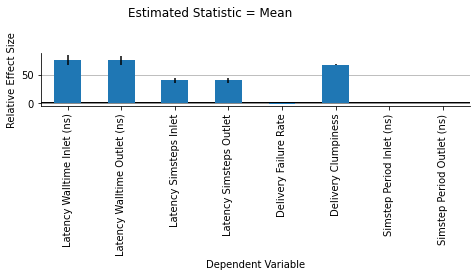

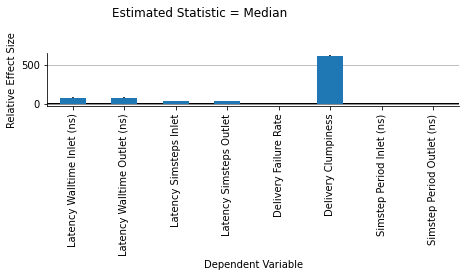

In [51]:
for regression, subset in regression_results.groupby([
    'Regression Model',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Relative Effect Size 95% CI Lower Bound',
            err_ub='Relative Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,

        row='Num Simels Per Cpu',
        x='Dependent Variable',
        y='Relative Effect Size',
        estimated_statistic={
            'Quantile Regression' : 'Median',
            'Ordinary Least Squares Regression' : 'Mean',
        }[regression],
        size_inches=(8, 8),
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
    )


teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.png
teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size+ext=.pdf
teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=relative-effect-size

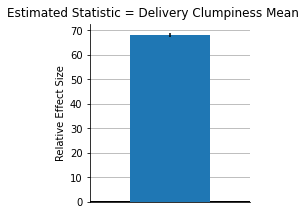

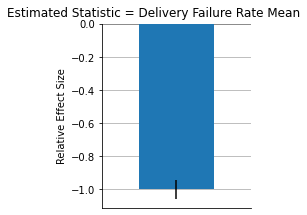

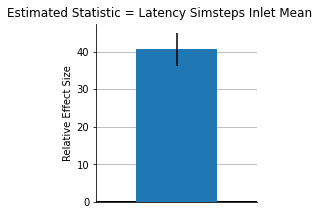

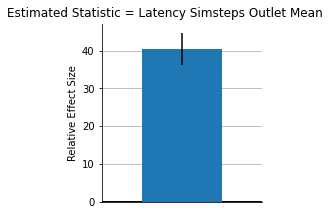

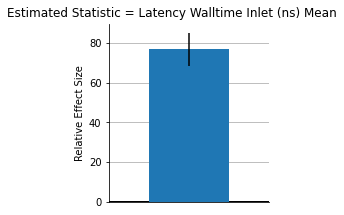

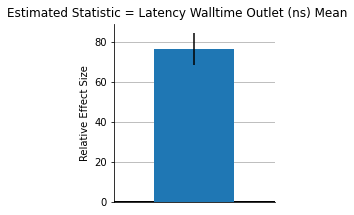

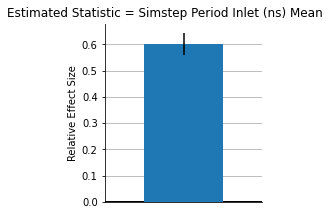

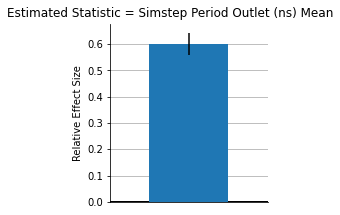

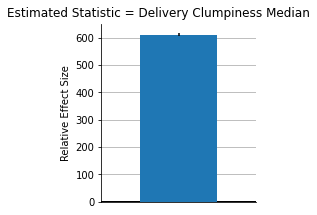

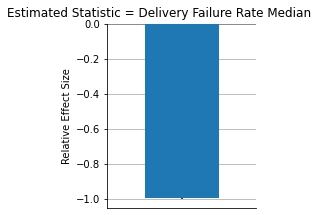

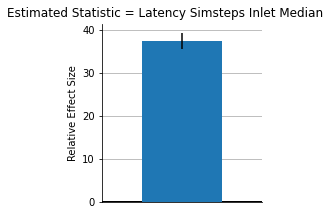

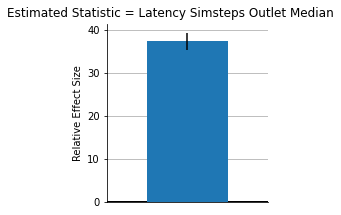

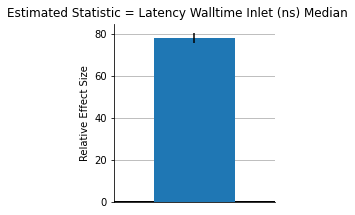

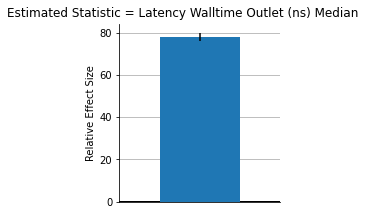

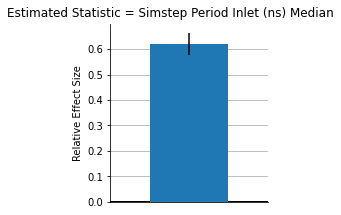

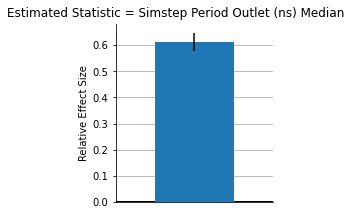

In [52]:
# relative estimates, alternate

for (regression, dependent_variable), subset in regression_results.groupby([
    'Regression Model',
    'Dependent Variable',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Relative Effect Size 95% CI Lower Bound',
            err_ub='Relative Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,

        row='Num Simels Per Cpu',
        y='Relative Effect Size',
        estimated_statistic={
            'Quantile Regression' : f'{dependent_variable} Median',
            'Ordinary Least Squares Regression' : f'{dependent_variable} Mean',
        }[regression],
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir=slugify(dependent_variable),
    )


teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/delivery-clumpiness/estimated-statistic=delivery-clumpiness-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/delivery-failure-rate/estimated-statistic=delivery-failure-rate-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.png
teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size+ext=.pdf
teeplots/latency-simsteps-inlet/estimated-statistic=latency-simsteps-inlet-mean+row=num-simels-per-cpu+transform=fit_regression+viz=lambda+y=absolute-effect-size

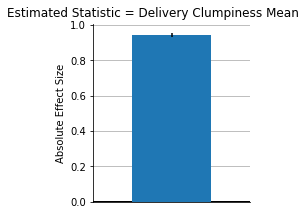

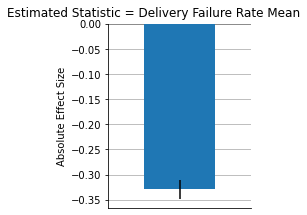

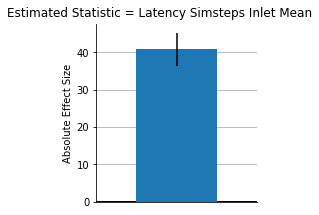

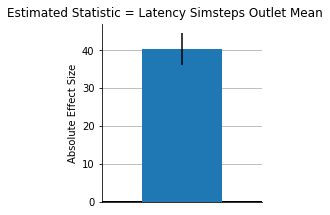

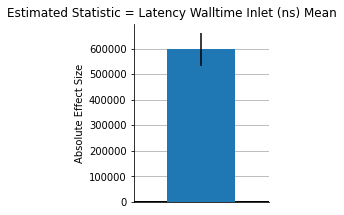

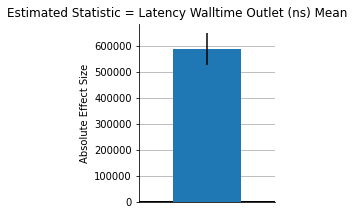

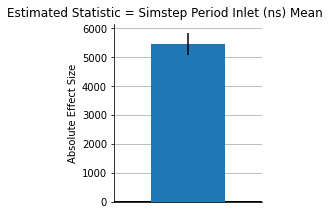

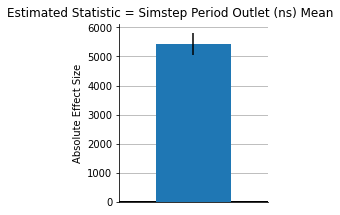

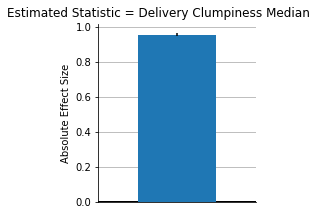

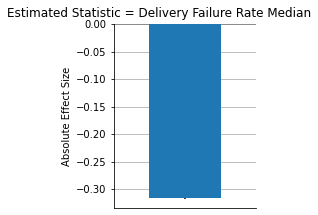

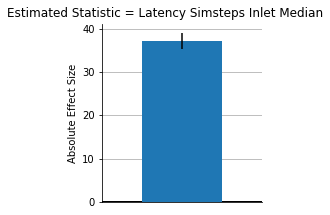

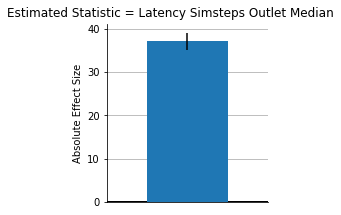

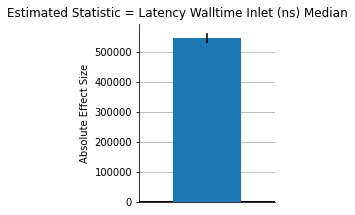

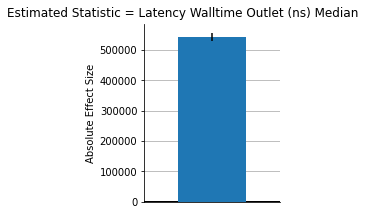

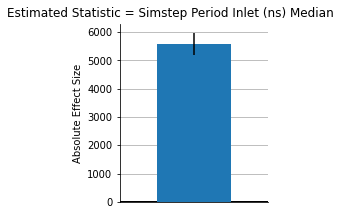

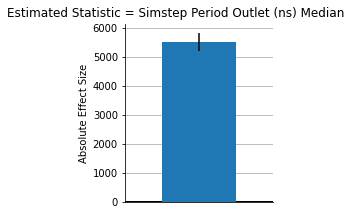

In [53]:
# absolute estimates

for (regression, dependent_variable), subset in regression_results.groupby([
    'Regression Model',
    'Dependent Variable',
]):
    tp.tee(
        # prevent filename length error
        lambda *args, **kwargs: facet_errplot(
            err_lb='Absolute Effect Size 95% CI Lower Bound',
            err_ub='Absolute Effect Size 95% CI Upper Bound',
            *args,
            **kwargs,
        ),
        data=subset,

        row='Num Simels Per Cpu',
        y='Absolute Effect Size',
        estimated_statistic={
            'Quantile Regression' : f'{dependent_variable} Median',
            'Ordinary Least Squares Regression' : f'{dependent_variable} Mean',
        }[regression],
        teeplot_outattrs={
            **{
                'transform' : 'fit_regression',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir=slugify(dependent_variable),
    )


In [54]:
def quantile_regplot(fit_reg=True, color=None, *args, **kwargs):
    x, y, data = kwargs['x'], kwargs['y'], kwargs['data']
    sns.regplot(
        *args,
        **kwargs,
        fit_reg=False,
        color=color,
    )

    if fit_reg:
        model = smf.quantreg(
            f"Q('{y}') ~ Q('{x}')",
            data
        )
        res = model.fit(q=0.5)
        m = res.params[f"Q('{x}')"]
        b = res.params['Intercept']

        m_ci = res.conf_int().loc[f"Q('{x}')"].tolist()
        b_ci = res.conf_int().loc['Intercept'].tolist()

        center_x = np.mean([data[x].min(), data[x].max()])
        center_y = m * center_x + b

        xs = sorted(set(data[x]) | {center_x})
        ys = [
            m * x_ + b
            for x_ in xs
        ]
        y1 = [ min(
                m_ * ( x_ - center_x ) + center_y
                for m_ in m_ci
        ) for x_ in xs ]
        y2 = [ max(
                m_ * ( x_ - center_x ) + center_y
                for m_ in m_ci
        ) for x_ in xs ]

        plt.gca().plot(
            xs,
            ys,
            color=color,
        )
        plt.gca().fill_between(
            xs,
            y1,
            y2,
            alpha=0.2,
            color=color,
        )


In [55]:
def unsplit_regression(*args, regplot, **kwargs):
    del kwargs['color']
    regplot(
        *args,
        **kwargs,
        color='black',
        fit_reg=False,
    )
    regplot(
        *args,
        **kwargs,
        color='purple',
        scatter=False,
    )

    # adapted from https://www.scivision.dev/matplotlib-force-integer-labeling-of-axis/
    plt.gca().xaxis.set_major_locator(
        matplotlib.ticker.MaxNLocator(
            integer=True,
        ),
    )

def facet_unsplit_regression(*, data, col=None, row=None, x, y, regression, **kwargs):
    g = sns.FacetGrid(
        data,
        col=col if col is not None and data[col].nunique() > 1 else None,
        row=row if row is not None and data[row].nunique() > 1 else None,
        margin_titles=True,
        sharey=False,
    )
    g.map_dataframe(
        unsplit_regression,
        regplot={
            'Ordinary Least Squares Regression' : sns.regplot,
            'Quantile Regression' : quantile_regplot,
        }[regression],
        x=x,
        y=y,
        **kwargs,
    )

    # adapted from https://stackoverflow.com/a/48208266
    g.set_axis_labels(x_var=x, y_var=y)

    # adapted from https://stackoverflow.com/a/29814281
    plt.gcf().subplots_adjust(top=0.8)
    plt.gcf().suptitle(regression)


## Latency Walltime Inlet (ns)


In [56]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Walltime Inlet (ns)'])
][[
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Walltime Inlet (ns),Latency Walltime Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-walltime-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/latency-walltime-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.png


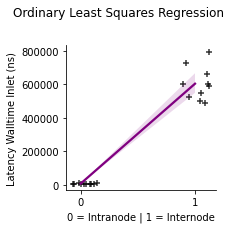

In [57]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Walltime Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Walltime Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-inlet-ns',
    )


teeplots/latency-walltime-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/latency-walltime-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-inlet-ns+ext=.png


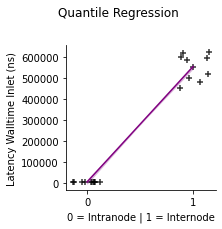

In [58]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Walltime Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-inlet-ns',
    )


## Latency Walltime Outlet (ns)


In [59]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Walltime Outlet (ns)'])
][[
    'Latency Walltime Inlet (ns)',
    'Latency Walltime Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Walltime Inlet (ns),Latency Walltime Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-walltime-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/latency-walltime-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.png


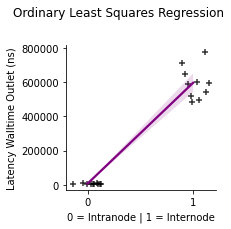

In [60]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Walltime Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)


data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Walltime Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-outlet-ns',
    )


teeplots/latency-walltime-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/latency-walltime-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-walltime-outlet-ns+ext=.png


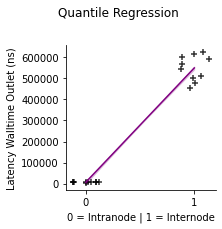

In [61]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Walltime Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-walltime-outlet-ns',
    )


## Latency Simsteps Inlet


In [62]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Simsteps Inlet'])
][[
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Simsteps Inlet,Latency Simsteps Outlet,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-simsteps-inlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.pdf
teeplots/latency-simsteps-inlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.png


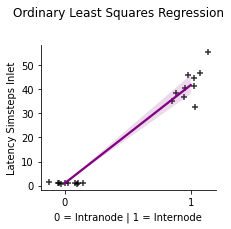

In [63]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Simsteps Inlet'] = (
    df_snapshot_diffs_copy['Num Puts Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Inlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Simsteps Inlet',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-inlet',
    )


teeplots/latency-simsteps-inlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.pdf
teeplots/latency-simsteps-inlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-inlet+ext=.png


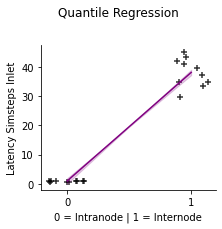

In [64]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Simsteps Inlet',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-inlet',
    )


## Latency Simsteps Outlet


In [65]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Latency Simsteps Outlet'])
][[
    'Latency Simsteps Inlet',
    'Latency Simsteps Outlet',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Latency Simsteps Inlet,Latency Simsteps Outlet,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/latency-simsteps-outlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.pdf
teeplots/latency-simsteps-outlet/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.png


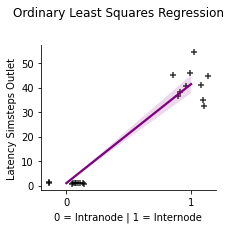

In [66]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs/nans
# see listing of infs/nans above
df_snapshot_diffs_copy['Latency Simsteps Outlet'] = (
    df_snapshot_diffs_copy['Num Pulls Attempted']
    / np.maximum(df_snapshot_diffs_copy['Num Round Trip Touches Outlet'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Simsteps Outlet',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-outlet',
    )


teeplots/latency-simsteps-outlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.pdf
teeplots/latency-simsteps-outlet/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=latency-simsteps-outlet+ext=.png


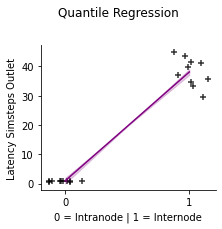

In [67]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Latency Simsteps Outlet',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='latency-simsteps-outlet',
    )


## Delivery Failure Rate


In [68]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Delivery Failure Rate'])
][[
    'Delivery Failure Rate',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Delivery Failure Rate,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/delivery-failure-rate/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.pdf
teeplots/delivery-failure-rate/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.png


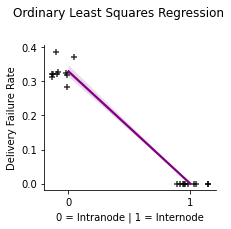

In [69]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Delivery Failure Rate',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-failure-rate',
    )


teeplots/delivery-failure-rate/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.pdf
teeplots/delivery-failure-rate/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-failure-rate+ext=.png


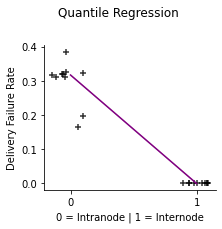

In [70]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Delivery Failure Rate',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-failure-rate',
    )


## Delivery Clumpiness


In [71]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Delivery Clumpiness'])
][[
    'Delivery Clumpiness',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Delivery Clumpiness,Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/delivery-clumpiness/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.pdf
teeplots/delivery-clumpiness/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.png


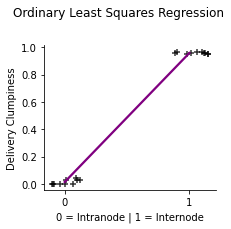

In [72]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Delivery Clumpiness',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-clumpiness',
    )


teeplots/delivery-clumpiness/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.pdf
teeplots/delivery-clumpiness/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=delivery-clumpiness+ext=.png


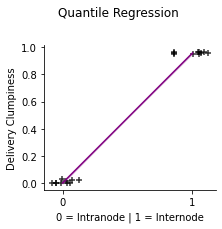

In [73]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Delivery Clumpiness',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='delivery-clumpiness',
    )


## Simstep Period Inlet (ns)


In [74]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Simstep Period Inlet (ns)'])
][[
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/simstep-period-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.pdf
teeplots/simstep-period-inlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.png


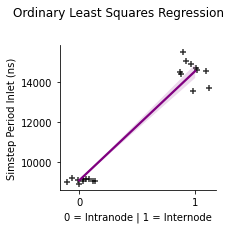

In [75]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs
# see listing of infs above
df_snapshot_diffs_copy['Simstep Period Inlet (ns)'] = (
    df_snapshot_diffs_copy['Inlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Puts Attempted'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Simstep Period Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-inlet-ns',
    )


teeplots/simstep-period-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.pdf
teeplots/simstep-period-inlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-inlet-ns+ext=.png


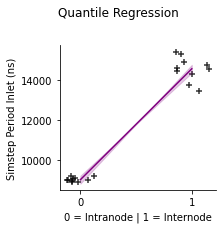

In [76]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Simstep Period Inlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-inlet-ns',
    )


## Simstep Period Outlet (ns)


In [77]:
df_snapshot_diffs[
    ~np.isfinite(df_snapshot_diffs['Simstep Period Outlet (ns)'])
][[
    'Simstep Period Inlet (ns)',
    'Simstep Period Outlet (ns)',
    'Snapshot',
    'Runtime Seconds Elapsed Outlet',
    'Hostname',
    'Replicate',
    'Num Simels Per Cpu',
    'Cpus Per Node',
    'Num Processes',
]]


,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Snapshot,Runtime Seconds Elapsed Outlet,Hostname,Replicate,Num Simels Per Cpu,Cpus Per Node,Num Processes


teeplots/simstep-period-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.pdf
teeplots/simstep-period-outlet-ns/marker=+regression=ordinary-least-squares-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-mean+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.png


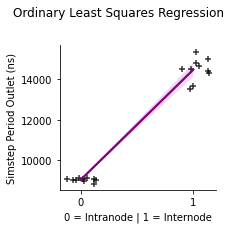

In [78]:
df_snapshot_diffs_copy = df_snapshot_diffs.copy()

# best-case approximation to replace infs
# see listing of infs above
df_snapshot_diffs_copy['Simstep Period Outlet (ns)'] = (
    df_snapshot_diffs_copy['Outlet-Nanoseconds Elapsed']
    / np.maximum(df_snapshot_diffs_copy['Num Pulls Attempted'], 1)
)

data = df_snapshot_diffs_copy.groupby([
    'Execution Instance UUID',
]).mean().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})

for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Simstep Period Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Ordinary Least Squares Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-mean',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-outlet-ns',
    )


teeplots/simstep-period-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.pdf
teeplots/simstep-period-outlet-ns/marker=+regression=quantile-regression+row=num-simels-per-cpu+transform=snapshot_diffs-groupby_exec_instance-median+viz=facet-unsplit-regression+x=0-intranode-1-internode+y=simstep-period-outlet-ns+ext=.png


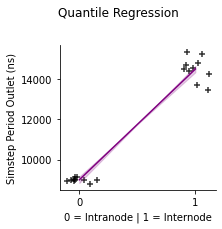

In [79]:
data = df_snapshot_diffs.groupby([
    'Execution Instance UUID',
]).median().reset_index().astype({
    'Num Processes' : 'int64',
    'Allocated Tasks Per Node' : 'int64',
    'Cpus Per Node' : 'int64',
    'Num Simels Per Cpu' : 'int64',
    multiprocessing_idx_mapped_title : 'int64',
})


for viz in facet_unsplit_regression,:
    tp.tee(
        viz,
        data=data,
        row='Num Simels Per Cpu',
        x=multiprocessing_idx_mapped_title,
        y='Simstep Period Outlet (ns)',
        marker='+',
        x_jitter=0.15,
        regression='Quantile Regression',
        teeplot_outattrs={
            **{
                'transform' : 'snapshot_diffs-groupby_exec_instance-median',
            },
            **nbm.collate_outattr_metadata(),
        },
        teeplot_subdir='simstep-period-outlet-ns',
    )


# Outlier Analysis


In [80]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 50)
    & (df_snapshot_diffs['Num Simels Per Cpu'] == 1)
]


,Process Instance UUID,Snapshot,Async Mode,Num Nodes,Allocated Tasks Per Node,Cpus Per Node,Num Processes,Log Num Processes,Num Simels Per Cpu,Replicate,proc,Hostname,Num Inlets,Num Outlets,Execution Instance UUID,Num Threads,Multiprocessing,0 = Intranode | 1 = Internode,Num Puts Attempted,Num Try Puts Attempted,Num Blocking Puts,Num Try Puts That Succeeded,Num Puts That Succeeded Eventually,Num Blocking Puts That Succeeded Immediately,Num Puts That Succeeded Immediately,Num Puts That Blocked,Num Dropped Puts,Num Reads Performed,Num Reads That Were Fresh,Num Reads That Were Stale,Num Revisions Pulled,Num Try Pulls Attempted,Num Blocking Pulls,Num Blocking Pulls That Blocked,Num Revisions From Try Pulls,Num Revisions From Blocking Pulls,Num Pulls Attempted,Num Pulls That Were Laden Eventually,Num Blocking Pulls That Were Laden Immediately,Num Blocking Pulls That Were Laden Eventually,Num Pulls That Were Laden Immediately,Num Try Pulls That Were Laden,Num Try Pulls That Were Unladen,Net Flux Through Duct,Num Round Trip Touches Inlet,Num Round Trip Touches Outlet,Row Final Timepoint (ns) Inlet,Row Final Timepoint (ns) Outlet,Runtime Seconds Elapsed Inlet,Runtime Seconds Elapsed Outlet,Fraction Messages Delivered,Delivery Success Rate,Delivery Failure Rate,Fraction Messages Dropped,Fraction Try Pulls That Were Laden,Round Trip Touches Per Attempted Put,Round Trip Touches Per Attempted Pull,Round Trip Touches Per Runtime Nanosecond,Latency Simsteps Inlet,Latency Simsteps Outlet,Delivery Clumpiness,Intermittancy,Inlet-Nanoseconds Elapsed,Outlet-Nanoseconds Elapsed,Simsteps Elapsed Inlet,Simsteps Elapsed Outlet,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Latency Walltime Inlet (ns),Latency Walltime Outlet (ns)
56,2b2141cd-ffd2-447f-9e17-ebe9ab6dbac1,2,3,2,1,1,2,0.5,1,2,0,lac-220,1,1,b2e63bda-3e4a-43e2-899a-da3378230d22,1,Internode,1,70046,70046,0,70046,70046,0,70046,0,0,213561.0,2018.0,211543.0,2018.0,71187.0,0.0,0.0,2018.0,0.0,71187.0,2018.0,0.0,0.0,2018.0,2018.0,69169.0,69265,1302,1362.0,1.011452e+09,1.020372e+09,120.5,120.5,1.0,1.0,0.0,0.0,0.028348,0.018588,0.019133,1.334807e-06,53.798771,52.266520,0.970866,0.970866,1.011452e+09,1.020372e+09,70046.0,71187.0,14439.826528,14333.687977,7.768449e+05,7.491720e+05
75,3af45557-cbf7-4a92-b92a-bb40352abc70,3,3,2,1,1,2,0.5,1,4,1,lac-221,1,1,fc527fca-3318-4815-b4af-b74f2f530306,1,Internode,1,64405,64405,0,64405,64405,0,64405,0,0,196308.0,1311.0,194997.0,1311.0,65437.0,0.0,0.0,1311.0,0.0,65437.0,1311.0,0.0,0.0,1311.0,1311.0,64126.0,76989,880,934.0,1.005665e+09,1.015628e+09,180.5,180.5,1.0,1.0,0.0,0.0,0.020035,0.013664,0.014273,9.196279e-07,73.187500,70.061028,0.979965,0.979965,1.005665e+09,1.015628e+09,64405.0,65437.0,15614.703330,15520.702554,1.142801e+06,1.087396e+06
77,3af45557-cbf7-4a92-b92a-bb40352abc70,5,3,2,1,1,2,0.5,1,4,1,lac-221,1,1,fc527fca-3318-4815-b4af-b74f2f530306,1,Internode,1,66756,66756,0,66756,66756,0,66756,0,0,203640.0,1129.0,202511.0,1129.0,67879.0,0.0,0.0,1129.0,0.0,67879.0,1129.0,0.0,0.0,1129.0,1129.0,66750.0,76564,752,806.0,1.005637e+09,1.016134e+09,300.5,300.5,1.0,1.0,0.0,0.0,0.016633,0.011265,0.011874,7.932025e-07,88.771277,84.217122,0.983367,0.983367,1.005637e+09,1.016134e+09,66756.0,67879.0,15064.375172,14969.783423,1.337284e+06,1.260712e+06
91,47a3d093-b93f-41a0-a04a-98b62414cb5c,1,3,2,1,1,2,0.5,1,9,1,lac-221,1,1,bcfea1a5-b11b-4446-8f22-2bf57d32f800,1,Internode,1,62443,62443,0,62443,62443,0,62443,0,0,189771.0,1292.0,188479.0,1292.0,63258.0,0.0,0.0,1292.0,0.0,63258.0,1292.0,0.0,0.0,1292.0,1292.0,61966.0,67166,900,942.0,1.006451e+09,1.012834e+09,60.5,60.5,1.0,1.0,0.0,0.0,0.020424,0.014413,0.014891,9.300634e-07,69.381111,67.152866,0.979576,0.979576,1.006451e+09,1.012834e+09,62443.0,63258.0,16117.921512,16011.162809,1.118279e+06,1.075195e+06
92,47a3d093-b93f-41a0-a04a-98b62414cb5c,2,3,2,1,1,2,0.5,1,9,1,lac-221,1,1,bcfea1a5-b11b-4446-8f22-2bf57d32f800,1,Internode,1,62657,62657,0,62657,62657,0,62657,0,0,187014.0,1200.0,185814.0,1200.0,62337.0,0.0,0.0,1200.0,0.0,

In [81]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 50)
    & (df_snapshot_diffs['Num Simels Per Cpu'] == 2048)
]


,Process Instance UUID,Snapshot,Async Mode,Num Nodes,Allocated Tasks Per Node,Cpus Per Node,Num Processes,Log Num Processes,Num Simels Per Cpu,Replicate,proc,Hostname,Num Inlets,Num Outlets,Execution Instance UUID,Num Threads,Multiprocessing,0 = Intranode | 1 = Internode,Num Puts Attempted,Num Try Puts Attempted,Num Blocking Puts,Num Try Puts That Succeeded,Num Puts That Succeeded Eventually,Num Blocking Puts That Succeeded Immediately,Num Puts That Succeeded Immediately,Num Puts That Blocked,Num Dropped Puts,Num Reads Performed,Num Reads That Were Fresh,Num Reads That Were Stale,Num Revisions Pulled,Num Try Pulls Attempted,Num Blocking Pulls,Num Blocking Pulls That Blocked,Num Revisions From Try Pulls,Num Revisions From Blocking Pulls,Num Pulls Attempted,Num Pulls That Were Laden Eventually,Num Blocking Pulls That Were Laden Immediately,Num Blocking Pulls That Were Laden Eventually,Num Pulls That Were Laden Immediately,Num Try Pulls That Were Laden,Num Try Pulls That Were Unladen,Net Flux Through Duct,Num Round Trip Touches Inlet,Num Round Trip Touches Outlet,Row Final Timepoint (ns) Inlet,Row Final Timepoint (ns) Outlet,Runtime Seconds Elapsed Inlet,Runtime Seconds Elapsed Outlet,Fraction Messages Delivered,Delivery Success Rate,Delivery Failure Rate,Fraction Messages Dropped,Fraction Try Pulls That Were Laden,Round Trip Touches Per Attempted Put,Round Trip Touches Per Attempted Pull,Round Trip Touches Per Runtime Nanosecond,Latency Simsteps Inlet,Latency Simsteps Outlet,Delivery Clumpiness,Intermittancy,Inlet-Nanoseconds Elapsed,Outlet-Nanoseconds Elapsed,Simsteps Elapsed Inlet,Simsteps Elapsed Outlet,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Latency Walltime Inlet (ns),Latency Walltime Outlet (ns)
